In [34]:
from iopath.common.file_io import g_pathmgr as pathmgr

import torch
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from functools import partial
import matplotlib.pyplot as plt

import baselines
import model_finetune
from gmae_st.data.get_dataset import get_dataset
from gmae_st.utils import misc
from gmae_st.data.utils import DX_DICT
from data.utils import collator

In [ ]:
def get_vis_dataset(
        dataset_dir,
        graph_token,
        n_hist,
        n_pred,
        num_visits,
        filter_list,
        filter_diagnosis,
        include_pet_volume,
        norm
):
    dataset_dict = get_dataset(
        dataset_type='brain',
        dataset_name='ADNI',
        data_dir=dataset_dir,
        n_hist=n_hist,
        n_pred=n_pred,
        num_visits=num_visits,
        task='class',
        filter_list=filter_list,
        filter_diagnosis=filter_diagnosis,
        graph_token=graph_token,
        mode='test',
        include_pet_volume=include_pet_volume,
        norm=norm
    )
    dataset_train = dataset_dict['train_dataset']
    dataset_test = dataset_dict['test_dataset']
    scaler = dataset_train.scaler
    sampler_test = torch.utils.data.SequentialSampler(dataset_test)

    data_sample = dataset_train[0]
    node_feature_dim = data_sample['x'].shape[-1]
    num_nodes = data_sample['adj'].shape[0]
    num_edges = len(data_sample['edge_attr'])

    # account for data.utils.collator changes
    num_spatial = torch.max(data_sample['spatial_pos']).item() + 1
    num_in_degree = torch.max(data_sample['in_degree']).item() + 1
    num_out_degree = torch.max(data_sample['out_degree']).item() + 1
    graph_info = {
        'node_feature_dim': node_feature_dim,
        'num_nodes': num_nodes,
        'num_edges': num_edges,
        'num_spatial': num_spatial,
        'num_in_degree': num_in_degree,
        'num_out_degree': num_out_degree
    }
    data_loader_test = torch.utils.data.DataLoader(
        dataset_test,
        sampler=sampler_test,
        batch_size=4,
        num_workers=8,
        pin_memory=True,
        drop_last=True,
        collate_fn=partial(
            collator,
            max_node=num_nodes,
            spatial_pos_max=num_spatial,
            graph_token=graph_token,
            scaler=scaler,
        ),
    )
    return data_loader_test, graph_info


def load_model(model_fp, model, pred_layer_keys=None):
    if not pred_layer_keys:
        pred_layer_keys = [
            'fc_project', 'end_conv_1', 'end_conv_2',
            'fc_channel', 'fc_hist', 'head',
        ]
    with pathmgr.open(model_fp, 'rb') as f:
        checkpoint = torch.load(f, map_location='cpu')

    if "model" in checkpoint.keys():
        checkpoint_model = checkpoint["model"]
    else:
        checkpoint_model = checkpoint["model_state"]

    state_dict = model.state_dict()
    for key in pred_layer_keys:
        suffix = ['.weight', '.bias']
        for suf in suffix:
            k = key + suf
            if k in checkpoint_model:
                del checkpoint_model[k]

    msg = model.load_state_dict(
        checkpoint_model,
        strict=False
    )
    print(msg)
    return model

In [43]:
def store_subject_info(subject_dict, outputs, batch):
    # batch['add_features'] is a list of dictionary of length batch_size, each dictionary corresponds to one subject
    subject_ids = [int(features.pop('rid').detach()) for features in batch['add_features']]

    for i, id in enumerate(subject_ids):
        if id in subject_dict:
            subject_dict[id]['rep'] += outputs[i]
            subject_dict[id]['count'] += 1
            for k, d in batch['add_features'][i].items():
                subject_dict[id][k].append(d)
        else:
            subject_dict[id] = dict()
            subject_dict[id]['count'] = 1
            subject_dict[id]['rep'] = outputs[i]
            for k, d in batch['add_features'][i].items():
                subject_dict[id][k] = [d]
    return subject_dict


@torch.no_grad()
def get_subject_rep(
        model,
        data_loader_test
):
    subject_dict = dict()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    for batch in data_loader_test:
        batch = misc.prepare_batch(batch, device=device)
        scaler = None if 'scaler' not in batch else batch['scaler']
        samples, _ = batch['x'], batch['y']

        if isinstance(model, model_finetune.GraphEncoder):
            x, attn_bias = model.blocks.compute_mods(batch)
            latent, _, x_shape = model.forward_encoder(x, attn_bias)
            latent = model.norm(latent)
        else:
            latent = model.forward_encoder(batch)
        subject_dict = store_subject_info(
            subject_dict=subject_dict,
            outputs=latent,
            batch=batch
        )
    return subject_dict

In [58]:
def tSNE_subjects(
        subject_dict,
        num_clusters=3,
        n_components_pca=64,
        n_components_tsne=2,
        tsne_perplexity=30,
        seed=0
):
    # Convert subject representations to a list for easier processing
    reps = []
    rids = []
    for rid, d in subject_dict.items():
        d['rep'] = d['rep'] / d['count']  # Normalize the representations
        d['rep_aggr'] = d['rep'].mean(dim=0)  # Aggregate over nodes
        d['DX_final'] = max([DX_DICT[dx] for dx in d['DX']])  # Final diagnosis
        reps.append(d['rep_aggr'].cpu().numpy())
        rids.append(rid)

    # Stack all subject representations into a matrix [num_subjects, feature_dim]
    reps = np.stack(reps)

    # Apply PCA to reduce dimensionality to n_components_pca
    pca = PCA(n_components=n_components_pca)
    reps_pca = pca.fit_transform(reps)
    # Explained variance for each component
    explained_variance_ratio = pca.explained_variance_ratio_

    # Cumulative explained variance
    cumulative_explained_variance = np.cumsum(explained_variance_ratio)
    print('explained variance ratio for first 5 components', explained_variance_ratio[:5], 'total explained variance',
          cumulative_explained_variance[:5])

    # Apply t-SNE to further reduce dimensionality to n_components_tsne (typically 2 for visualization)
    tsne = TSNE(
        n_components=n_components_tsne,
        perplexity=tsne_perplexity,
        random_state=seed
    )
    reps_tsne = tsne.fit_transform(reps_pca)

    # Apply KMeans to identify clusters in the t-SNE space
    kmeans = KMeans(
        n_clusters=num_clusters,
        random_state=seed
    )
    cluster_labels = kmeans.fit_predict(reps_tsne)

    # Store the t-SNE results and cluster labels back in the subject dictionary
    for i, rid in enumerate(rids):
        subject_dict[rid]['rep_tsne'] = reps_tsne[i]
        subject_dict[rid]['cluster'] = cluster_labels[i]
    return subject_dict


def visualize_tsne(subject_dict, num_clusters):
    # Extract t-SNE representations, clusters, and diagnoses
    tsne_reps = []
    clusters = []
    diagnoses = []
    for rid, d in subject_dict.items():
        tsne_reps.append(d['rep_tsne'])
        clusters.append(d['cluster'])
        diagnoses.append(d['DX_final'])

    tsne_reps = np.stack(tsne_reps)

    # Define a colormap with discrete colors for clusters
    cmap = plt.get_cmap('tab10', num_clusters)
    colors = cmap(np.arange(num_clusters))

    plt.figure(figsize=(10, 7))

    # Create a scatter plot for each cluster and add to the legend
    for cluster in range(num_clusters):
        idx = np.where(np.array(clusters) == cluster)
        scatter = plt.scatter(tsne_reps[idx, 0], tsne_reps[idx, 1],
                              color=colors[cluster], s=100, alpha=0.6, label=f'Cluster {cluster}')

    # Add legend for clusters
    plt.legend(title="Clusters")

    # Annotate each point with its diagnosis number
    for i, dx in enumerate(diagnoses):
        plt.text(tsne_reps[i, 0], tsne_reps[i, 1], str(dx), fontsize=9, ha='center', va='center')

    plt.title('t-SNE Visualization with Cluster Coloring and Diagnosis Labels')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.grid(True)
    plt.show()

In [59]:
def vis_pipeline(
        model_fp,
        dataset_args=None,
        num_clusters=4,
        pca_components=32,
        tsne_perplexity=30,
        seed=0,
):
    if not dataset_args:
        n_hist, n_pred, num_visits = 1, 0, 1
        filter_list = (0, 1, 0)
        filter_diagnosis, include_pet_volume = False, False
        norm = True
        graph_token = False
        dataset_dir = ''
        dataset_args = {
            'dataset_dir': dataset_dir,
            'n_hist': n_hist,
            'n_pred': n_pred,
            'num_visits': num_visits,
            'filter_list': filter_list,
            'filter_diagnosis': filter_diagnosis,
            'include_pet_volume': include_pet_volume,
            'norm': norm,
            'graph_token': graph_token,
        }
    loader, graph_info = get_vis_dataset(
        **dataset_args
    )
    dataset_args.update(graph_info)
    print(dataset_args)
    model = model_finetune.graph_pred_mini(
        sep_pos_embed=False,
        cls_token=False if dataset_args['graph_token'] else True,
        **dataset_args
    )
    model = load_model(
        model_fp=model_fp,
        model=model,
    )
    subject_dict = get_subject_rep(
        model=model,
        data_loader_test=loader
    )
    subject_dict = tSNE_subjects(
        subject_dict=subject_dict,
        num_clusters=num_clusters,
        n_components_pca=pca_components,
        tsne_perplexity=tsne_perplexity,
        seed=seed
    )
    visualize_tsne(subject_dict, 4)
    return subject_dict

In [9]:
subject_dict_sum = {rid: d for rid, d in subject_dict.items() if d['count'] > 1}
subject_dict_one = {rid: d for rid, d in subject_dict.items() if d['count'] == 1}

Getting ADNI data with 
num_visits: 1, 
Amyloid-Beta PET scans
total subjects: 1144
train subjects:  800 val subjects:  115 test subjects:  229
class labels: ['CN' 'Dementia' 'MCI'], counts: [317 159 324]
initial class prob: [0.39625 0.19875 0.405  ]
Using normalization with mean: [1.17045309], std: [0.25737145]
 > ADNI loaded!
{'train_dataset': GraphTemporalDataset(1662), 'valid_dataset': GraphTemporalDataset(240), 'test_dataset': GraphTemporalDataset(473), 'class_init_prob': array([0.39625, 0.19875, 0.405  ])}
 > dataset info ends
{'dataset_dir': '', 'n_hist': 1, 'n_pred': 0, 'num_visits': 1, 'filter_list': (0, 1, 0), 'filter_diagnosis': False, 'include_pet_volume': False, 'norm': True, 'graph_token': False, 'node_feature_dim': 1, 'num_nodes': 68, 'num_edges': 1394, 'num_spatial': 19, 'num_in_degree': 42, 'num_out_degree': 42}
model initialized
_IncompatibleKeys(missing_keys=['end_conv_1.weight', 'batch_norm.weight', 'batch_norm.bias', 'batch_norm.running_mean', 'batch_norm.running_v

/Users/markbai/anaconda3/envs/gmae_st/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


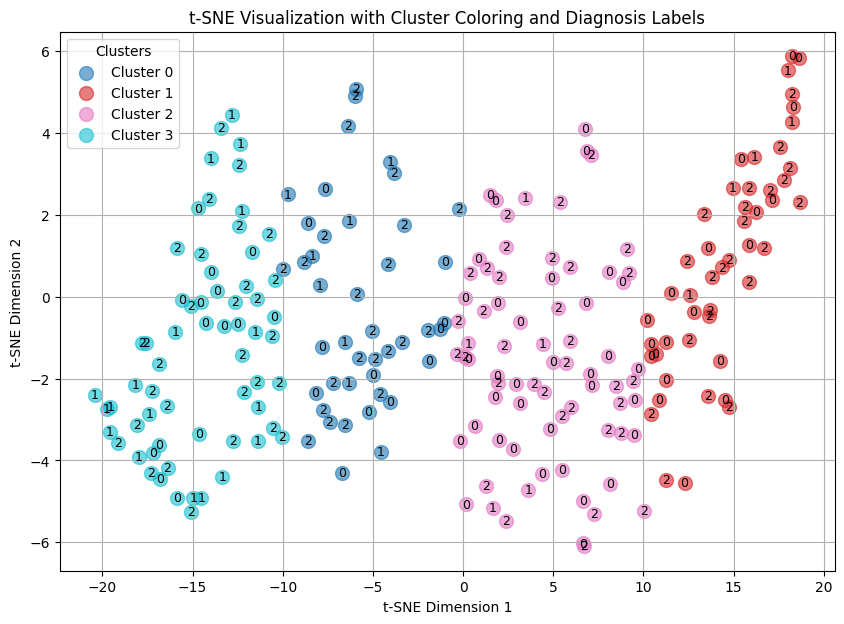

{56: {'count': 5,
  'rep': tensor([[ 0.0594, -0.0443, -0.6300,  ..., -1.5748, -0.7576,  0.0711],
          [ 0.4232, -0.4158, -0.3927,  ..., -1.6645, -0.6046,  0.8730],
          [ 0.3160, -0.5674,  0.7352,  ..., -0.9075,  0.6397,  0.7493],
          ...,
          [-1.0347, -0.6419, -0.2357,  ..., -0.3542, -1.2872, -0.6850],
          [ 0.3004, -0.4360,  0.4401,  ..., -0.9317, -0.0257,  0.8431],
          [-0.3285, -0.2297,  0.1484,  ..., -0.1423,  0.5553, -0.9803]]),
  'viscode': ['m60', 'm108', 'm84', 'm144', 'm168'],
  'DX_CHANGE': [tensor(1., dtype=torch.float64),
   tensor(7., dtype=torch.float64),
   tensor(4., dtype=torch.float64),
   tensor(4., dtype=torch.float64),
   tensor(4., dtype=torch.float64)],
  'APOE4': [tensor(0., dtype=torch.float64),
   tensor(0., dtype=torch.float64),
   tensor(0., dtype=torch.float64),
   tensor(0., dtype=torch.float64),
   tensor(0., dtype=torch.float64)],
  'DX_bl': ['CN', 'CN', 'CN', 'CN', 'CN'],
  'DX': ['CN', 'CN', 'MCI', 'MCI', 'MCI'],
  '

In [60]:
vis_pipeline(
    '/Users/markbai/Documents/gmae_st/gmae_st/test_brain_pretrain/checkpoint-00003.pth'
)

Getting ADNI data with 
num_visits: 1, 
Amyloid-Beta PET scans
total subjects: 1144
train subjects:  800 val subjects:  115 test subjects:  229
class labels: ['CN' 'Dementia' 'MCI'], counts: [317 159 324]
initial class prob: [0.39625 0.19875 0.405  ]
Using normalization with mean: [1.17045309], std: [0.25737145]
 > ADNI loaded!
{'train_dataset': GraphTemporalDataset(1662), 'valid_dataset': GraphTemporalDataset(240), 'test_dataset': GraphTemporalDataset(473), 'class_init_prob': array([0.39625, 0.19875, 0.405  ])}
 > dataset info ends
{'dataset_dir': '', 'n_hist': 1, 'n_pred': 0, 'num_visits': 1, 'filter_list': (0, 1, 0), 'filter_diagnosis': False, 'include_pet_volume': False, 'norm': True, 'graph_token': False, 'node_feature_dim': 1, 'num_nodes': 68, 'num_edges': 1394, 'num_spatial': 19, 'num_in_degree': 42, 'num_out_degree': 42}
model initialized
_IncompatibleKeys(missing_keys=['end_conv_1.weight', 'batch_norm.weight', 'batch_norm.bias', 'batch_norm.running_mean', 'batch_norm.running_v

/Users/markbai/anaconda3/envs/gmae_st/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


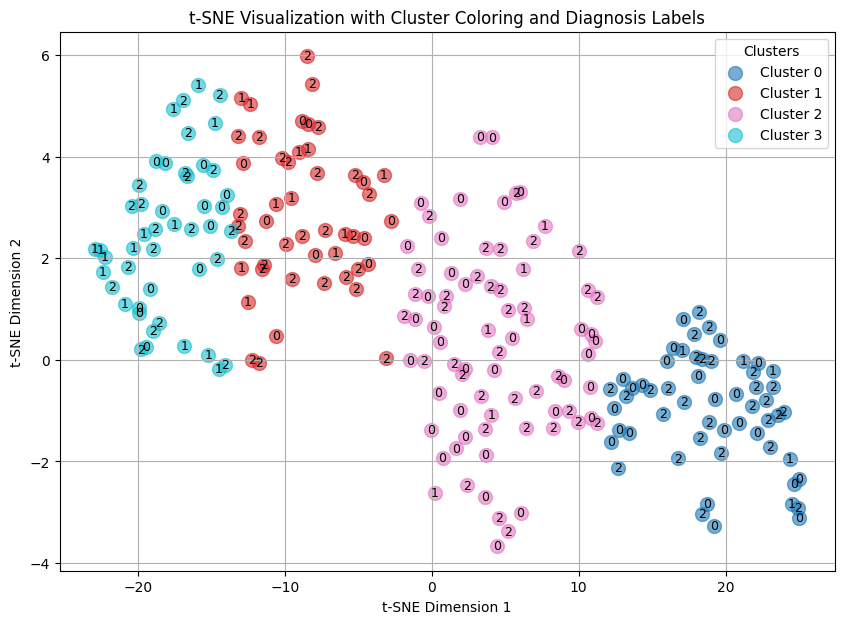

{56: {'count': 5,
  'rep': tensor([[-0.5803, -0.0549,  1.1214,  ...,  0.1306, -0.5156,  0.9883],
          [-0.6659,  0.1138,  1.0418,  ...,  0.1890, -0.6087,  1.1731],
          [-0.9161, -0.1443,  1.4588,  ...,  1.1002, -0.2242,  0.4769],
          ...,
          [-1.1040, -0.6321,  1.5617,  ..., -0.0539, -1.0935,  0.2757],
          [-0.8275, -0.2886,  1.4472,  ...,  0.4871, -0.1887,  0.6317],
          [-0.9456, -0.1697,  1.0619,  ...,  0.7132, -0.2248,  0.6594]]),
  'viscode': ['m60', 'm108', 'm84', 'm144', 'm168'],
  'DX_CHANGE': [tensor(1., dtype=torch.float64),
   tensor(7., dtype=torch.float64),
   tensor(4., dtype=torch.float64),
   tensor(4., dtype=torch.float64),
   tensor(4., dtype=torch.float64)],
  'APOE4': [tensor(0., dtype=torch.float64),
   tensor(0., dtype=torch.float64),
   tensor(0., dtype=torch.float64),
   tensor(0., dtype=torch.float64),
   tensor(0., dtype=torch.float64)],
  'DX_bl': ['CN', 'CN', 'CN', 'CN', 'CN'],
  'DX': ['CN', 'CN', 'MCI', 'MCI', 'MCI'],
  '

In [61]:
vis_pipeline(
    '/Users/markbai/Documents/gmae_st/gmae_st/test_brain_pretrain/checkpoint-00000.pth'
)